# DataSets

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import bs4 as bs
import requests
import lxml
#import missingno
from functools import reduce

## Sectors Dataset

El orden está en https://www.tradingview.com/markets/indices/quotes-snp/

La referencia de los códigos está en https://www.spglobal.com/marketintelligence/en/documents/112727-gics-mapbook_2018_v3_letter_digitalspreads.pdf

El sector de energía (^SP500-10) en Yahoo Finance se llama ^GSPE

### Análisis de datos faltantes

In [74]:
# TAMBIÉN ESTA EL DE REAL STATE (^SP500-60) PERO ESE NO LO METE REFFINOT
selected_stocks = ['^GSPE', '^SP500-15','^SP500-20','^SP500-25','^SP500-30','^SP500-35','^SP500-40','^SP500-45','^SP500-50','^SP500-55']
sp500_sectors = yf.download(selected_stocks,"1995-01-01","2016-08-31")

[*********************100%***********************]  10 of 10 completed


In [76]:
sp500_sectors['Close'].shape

(5455, 10)

### Análisis de datos faltantes

Mediante la librería *missingno* se grafica el porcentaje de datos no faltantes en cada sub índice. Es posible observar que no se cuenta con datos faltantes. 

<AxesSubplot:>

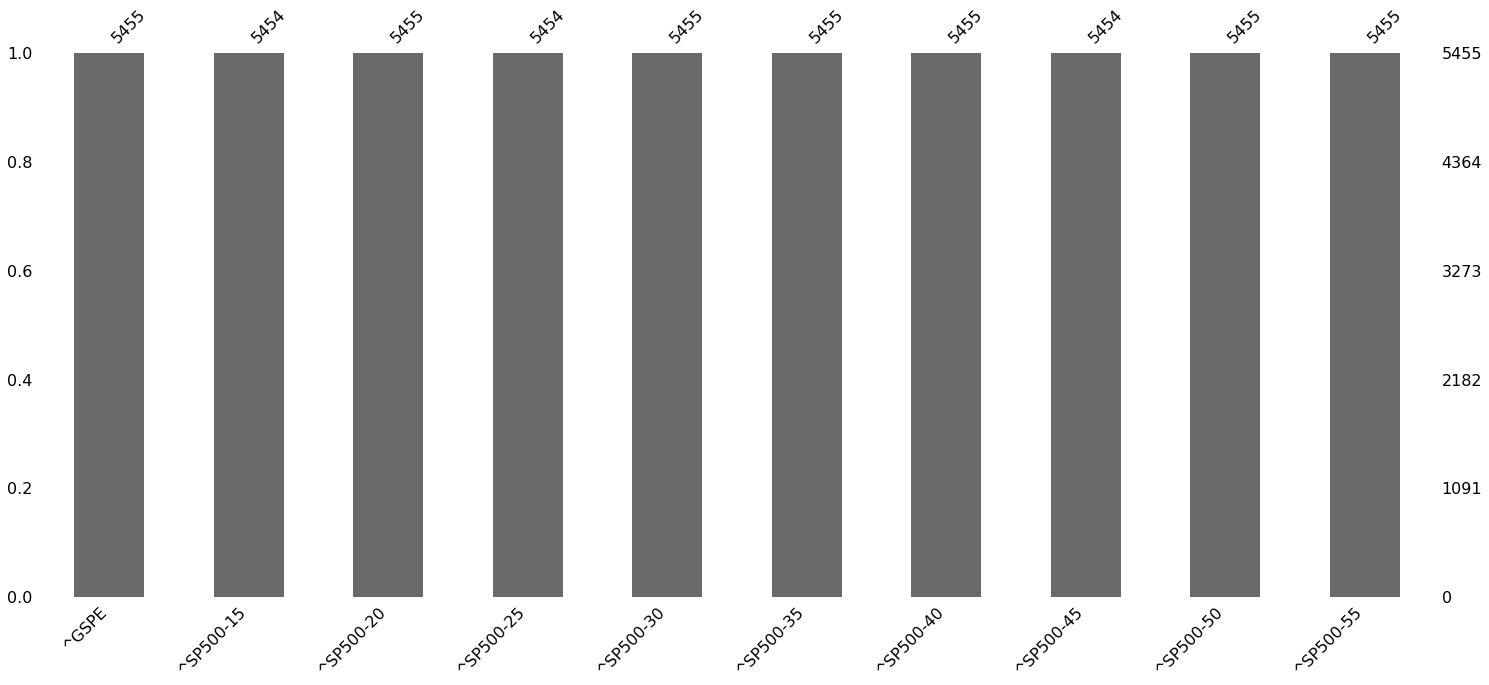

In [77]:
missingno.bar(sp500_sectors['Close'])

In [78]:
sp_500_sectors_close = pd.DataFrame(sp500_sectors['Close'])

In [79]:
sp_500_sectors_close.shape

(5455, 10)

### Persistencia de los datos

In [80]:
sp_500_sectors_close.to_csv('data/sp_500_sectors_close.csv',index = True)

### Obtención de retornos
Se obtienen los retornos porcentuales diarios

In [81]:
sp_500_sectors_returns = np.diff(sp_500_sectors_close, axis = 0)/sp_500_sectors_close.iloc[:-1,:]

In [83]:
sp_500_sectors_returns

,^GSPE,^SP500-15,^SP500-20,^SP500-25,^SP500-30,^SP500-35,^SP500-40,^SP500-45,^SP500-50,^SP500-55
Date,,,,,,,,,,
1995-01-03,0.003888,0.001506,0.000599,0.009734,-0.002794,0.001907,0.009945,0.003332,0.000100,0.006664
1995-01-04,0.000000,0.000401,0.003594,0.003280,-0.009307,0.000401,-0.000591,-0.002013,-0.001799,-0.004644
1995-01-05,-0.002582,0.010022,0.004079,-0.000297,-0.001515,-0.004806,0.002069,0.010588,-0.009211,0.002283
1995-01-06,-0.001394,0.003870,0.001288,-0.000495,0.000000,-0.006539,0.000983,0.007084,0.000707,-0.002080
1995-01-09,-0.003290,0.003361,0.003463,-0.004659,-0.001113,0.002025,0.002750,0.021599,-0.000606,0.000992
...,...,...,...,...,...,...,...,...,...,...
2016-08-23,-0.002694,-0.011588,-0.002842,-0.004454,-0.001604,-0.016074,-0.001236,-0.005358,-0.000347,0.000000
2016-08-24,-0.002916,0.004912,-0.000826,-0.003684,-0.004212,-0.007938,0.002816,0.001241,0.004110,0.000394
2016-08-25,-0.003392,-0.006061,-0.002813,-0.002704,-0.004696,0.003513,0.000617,0.001444,-0.010781,-0.021126


<AxesSubplot:xlabel='Date'>

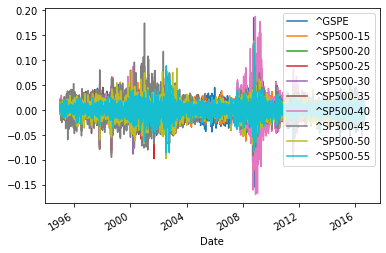

In [84]:
sp_500_sectors_returns.plot()

In [85]:
sp_500_sectors_returns.to_csv('data/sp_500_sectors_returns.csv')

## S&P 500

### Descarga de la información
Siguiendo la metodología de Raffinot, primero se obtienen los activos que estaban en el índice en Diciembre del 2021, se obtiene la información histórica y posteriormente nos quedamos únicamente con aquellos activos que cuentan con historia suficiente (approx 3 años hacia atrás, es decir, 2018).

source: https://codingandfun.com/python-scraping-how-to-get-sp-500-companies-from-wikipedia/

Para ver la composición del índice en otros tiempos consultar las versiones en: https://en.wikipedia.org/w/index.php?title=List_of_S%26P_500_companies&offset=20200217154235%7C941267549&action=history

A continuación se hace el web scraping de los componentes del S&P 500 a finales del 2021 en la versión de archivo de Wikipedia y mediante Beautifull Soup se obtienen los tickers correspondientes.

In [3]:
resp = requests.get('https://en.wikipedia.org/w/index.php?title=List_of_S%26P_500_companies&oldid=1062834329')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [4]:
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
tickers = list(map(lambda s: s.strip(), tickers))

En total se tienen 505 empresas, pues algunas de las empresas en el índice tienen más de una familia de acciones. 

In [5]:
len(tickers)

505

In [6]:
sp500_tabla = pd.read_html(str(table))[0]

In [7]:
tickers2 = list(sp500_tabla.sort_values('GICS Sector')['Symbol'])
sectors = list(sp500_tabla.sort_values('GICS Sector')['GICS Sector'])

In [11]:
tickers2[tickers2.index("BRK.B")] = "BRK-B"
tickers2[tickers2.index("BF.B")] = "BF-B"

La nomenclatura utilizada en Wikipedia no es la misma que la de Yahoo Finance, por lo que hay que cambiar los puntos por guiones.

In [12]:
sp_500_original = yf.download(tickers2, "2012-01-01", "2021-12-31")

[*********************100%***********************]  505 of 505 completed


In [38]:
sp_500_original.to_csv('./data/sp_500_original.csv', index = True)

In [49]:
sp_500_original_close = sp_500_original['Close']

In [39]:
sp_500_original_close.to_csv('./data/sp_500_original_close.csv', index = True)

In [18]:
sp_500_original_close.shape

(2523, 505)

### Análisis de Datos Faltantes

Se observa a continuación que hay 38 activos que tienen más de un 10% de datos faltantes, y por lo tanto estos activos deben ser eliminados del conjunto de datos

In [50]:
sp_500_remove = list((sp_500_original_close.isna().sum().sort_values() > sp_500_original_close.shape[0]*.10).tail(38).index)
sp_500_remove

['ABBV',
 'NCLH',
 'ZTS',
 'IQV',
 'NWS',
 'NWSA',
 'CDW',
 'TWTR',
 'ALLE',
 'HLT',
 'PAYC',
 'ANET',
 'SYF',
 'CTLT',
 'CZR',
 'CFG',
 'KEYS',
 'QRVO',
 'SEDG',
 'ETSY',
 'WRK',
 'PYPL',
 'KHC',
 'HPE',
 'UA',
 'FTV',
 'HWM',
 'LW',
 'IR',
 'CDAY',
 'MRNA',
 'FOXA',
 'FOX',
 'DOW',
 'CTVA',
 'CARR',
 'OTIS',
 'OGN']

In [51]:
sp_500_original_clean = sp_500_original_close.drop(columns = sp_500_remove)

In [53]:
sp_500_original_clean.shape

(2523, 467)

El último día no se tiene información para ninǵun activo, por lo que se quita del conjunto de datos.

In [54]:
sp_500_original_clean = sp_500_original_clean.drop('2021-12-31', axis = 0)

In [55]:
sp_500_original_clean.shape

(2522, 467)

Para los activos que quedan que aún tienen datos faltantes, se imputará mediante un spline de orden 3. para verificar el correcto funcionamiento del spline, primero se experimentará con la accion de Apple. A continuación se muestran los días para los que se tiene información vacía.

In [62]:
sp_500_original_clean['AAPL'][sp_500_original_clean['AAPL'].isna() == True]

Date
2012-10-29   NaN
2016-01-18   NaN
2017-01-02   NaN
2017-02-20   NaN
2018-01-01   NaN
2018-12-05   NaN
Name: AAPL, dtype: float64

A continuación se realiza la interpolación de prueba. Notar que el método es spline, el orden es 3 y el parámetro "s" es un factor de suavizamiento (cuando s=0, el spline interpola sobre todos los puntos).

Más sobre el factor de suavizamiento: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html
Más sobre por que está forma de aplicar el spline es más rápido:
https://stackoverflow.com/questions/32501347/how-to-apply-cubic-spline-interpolation-over-long-pandas-series

In [73]:
spli = sp_500_original_clean['AAPL'].interpolate(method = "spline", order = 3, s=0.)
spli

Date
2012-01-03     14.686786
2012-01-04     14.765714
2012-01-05     14.929643
2012-01-06     15.085714
2012-01-09     15.061786
                 ...    
2021-12-23    176.279999
2021-12-27    180.330002
2021-12-28    179.289993
2021-12-29    179.380005
2021-12-30    178.199997
Name: AAPL, Length: 2522, dtype: float64

Se revisa el valor que se imputo mediante el spline a continuación, mostrando también valores del mismo mes para verificar que la imputación sea plausible.

In [78]:
spli.loc[(spli.index.month ==10) &(spli.index.year ==2012)]

Date
2012-10-01    23.549643
2012-10-02    23.618214
2012-10-03    23.980356
2012-10-04    23.814285
2012-10-05    23.306786
2012-10-08    22.791786
2012-10-09    22.708929
2012-10-10    22.889643
2012-10-11    22.432142
2012-10-12    22.489643
2012-10-15    22.670000
2012-10-16    23.206785
2012-10-17    23.021786
2012-10-18    22.594286
2012-10-19    21.780001
2012-10-22    22.643929
2012-10-23    21.905714
2012-10-24    22.029642
2012-10-25    21.769285
2012-10-26    21.571428
2012-10-29    21.147030
2012-10-31    21.261429
Name: AAPL, dtype: float64

A continuación se realiza la imputación en el conjunto de datos

In [83]:
sp_500_original_clean = sp_500_original_clean.interpolate(method = "spline", order = 3, s=0., axis = 'index')

Se revisa de nuevo el valor imputado para AAPL en el día 2012-10-29 para verificar que el spline se llevara a cabo de la misma forma:

In [84]:
sp_500_original_clean['AAPL'].loc[(sp_500_original_clean.index.month ==10) &(sp_500_original_clean.index.year ==2012)]

Date
2012-10-01    23.549643
2012-10-02    23.618214
2012-10-03    23.980356
2012-10-04    23.814285
2012-10-05    23.306786
2012-10-08    22.791786
2012-10-09    22.708929
2012-10-10    22.889643
2012-10-11    22.432142
2012-10-12    22.489643
2012-10-15    22.670000
2012-10-16    23.206785
2012-10-17    23.021786
2012-10-18    22.594286
2012-10-19    21.780001
2012-10-22    22.643929
2012-10-23    21.905714
2012-10-24    22.029642
2012-10-25    21.769285
2012-10-26    21.571428
2012-10-29    21.147030
2012-10-31    21.261429
Name: AAPL, dtype: float64

Como es posible observar a continuación, aún hay datos faltantes. Esto se debe a que se trata de activos que fueron listados después del 2012 y por lo tanto tienen grandes porciones de datos faltantes al inicio que no pueden ser imputados mediante spline. Estos activos son 7 y también se remueven

In [117]:
sp_500_remove_extra = list(sp_500_original_clean.isna().sum().sort_values().tail(7).index)
sp_500_remove_extra

['EPAM', 'ENPH', 'PSX', 'AMCR', 'FB', 'NOW', 'FANG']

Como ejemplo para mostrar lo que se comentó sobre que los datos faltantes de estos 7 activos están al inicio, se muestra el caso de EPAM. A continuación se muestran los días en los que se tienen valores faltantes, y es posible constatar que estos están siempre al inicio del periodo.

In [112]:
list(sp_500_original_clean['EPAM'][sp_500_original_clean['EPAM'].isna() == True].index)

[Timestamp('2012-01-03 00:00:00'),
 Timestamp('2012-01-04 00:00:00'),
 Timestamp('2012-01-05 00:00:00'),
 Timestamp('2012-01-06 00:00:00'),
 Timestamp('2012-01-09 00:00:00'),
 Timestamp('2012-01-10 00:00:00'),
 Timestamp('2012-01-11 00:00:00'),
 Timestamp('2012-01-12 00:00:00'),
 Timestamp('2012-01-13 00:00:00'),
 Timestamp('2012-01-17 00:00:00'),
 Timestamp('2012-01-18 00:00:00'),
 Timestamp('2012-01-19 00:00:00'),
 Timestamp('2012-01-20 00:00:00'),
 Timestamp('2012-01-23 00:00:00'),
 Timestamp('2012-01-24 00:00:00'),
 Timestamp('2012-01-25 00:00:00'),
 Timestamp('2012-01-26 00:00:00'),
 Timestamp('2012-01-27 00:00:00'),
 Timestamp('2012-01-30 00:00:00'),
 Timestamp('2012-01-31 00:00:00'),
 Timestamp('2012-02-01 00:00:00'),
 Timestamp('2012-02-02 00:00:00'),
 Timestamp('2012-02-03 00:00:00'),
 Timestamp('2012-02-06 00:00:00'),
 Timestamp('2012-02-07 00:00:00')]

In [119]:
sp_500_original_clean = sp_500_original_clean.drop(columns = sp_500_remove_extra)

In [120]:
sp_500_original_clean.shape

(2522, 460)

Se constata que ya no se tienen datos faltantes:

In [121]:
sp_500_original_clean.isna().sum().sort_values()

A       0
O       0
NXPI    0
NWL     0
NVR     0
       ..
EMN     0
EL      0
EIX     0
ED      0
ZION    0
Length: 460, dtype: int64

Se obtiene entonces un conjunto de datos "limpio" con **dimesiones $2522 \times 460$**. A continuación se guardan los precios de cierre ya limpios.

In [122]:
sp_500_original_clean.to_csv('./data/sp_500_original_clean.csv', index = True)

### Obtención de los retornos

In [128]:
sp_500_returns = sp_500_original_clean.pct_change(periods = 1).iloc[1:, :]
sp_500_returns.head(10)

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WYNN,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.007950,-0.017578,0.023444,0.005374,0.003415,-0.007671,-0.003879,-0.000378,-0.010150,-0.001388,...,-0.017197,-0.006584,-0.010635,0.000233,-0.000283,0.033015,0.006829,-0.013534,-0.007559,0.022063
2012-01-05,0.022382,0.087475,0.006363,0.011102,0.007592,0.008835,-0.002301,-0.019082,0.007072,0.004447,...,-0.010446,0.004418,0.008880,-0.003022,0.000848,-0.014247,0.007631,0.011840,-0.001410,0.028005
2012-01-06,0.010811,0.023766,0.004637,0.010454,0.002598,-0.007116,-0.009047,-0.001733,0.008427,-0.006641,...,-0.035186,-0.002933,-0.006486,-0.007463,-0.005932,-0.016797,0.007237,0.002600,-0.008192,0.001135
2012-01-09,0.026203,0.021429,-0.000280,-0.001586,-0.000518,0.003859,-0.000179,-0.001736,-0.006616,0.019499,...,-0.002805,0.000735,0.021759,0.004464,-0.004831,0.003973,-0.003843,0.007410,-0.004557,0.013605
2012-01-10,0.018760,0.000000,0.000839,0.003580,0.011408,-0.002746,0.004655,0.017201,0.023484,0.004372,...,0.008346,0.008082,0.001825,0.002573,0.014278,0.012267,0.006206,0.020964,0.009156,0.016219
2012-01-11,-0.004604,0.033217,0.006709,-0.001630,-0.010254,0.004405,-0.012297,0.019761,0.004110,0.004081,...,0.040547,-0.012755,-0.002429,-0.007466,0.009290,0.018765,0.015503,-0.003963,0.009073,0.018162
2012-01-12,0.015416,0.023689,-0.005137,-0.002745,0.005957,0.004386,-0.004691,0.005031,-0.003070,0.010837,...,-0.018679,-0.014766,0.018569,-0.003996,0.015063,-0.013814,-0.000985,-0.004340,-0.016859,0.008108
2012-01-13,-0.011640,-0.013223,-0.002652,-0.003750,-0.026777,-0.018559,0.004895,-0.012792,-0.008895,-0.018494,...,-0.017760,0.002248,-0.014047,0.001652,-0.008244,-0.002724,0.006080,-0.000363,-0.000572,-0.008043
2012-01-17,0.023810,-0.015075,0.008676,0.011648,0.013228,0.003893,0.005051,0.004507,0.013117,0.011469,...,0.037552,-0.001869,0.010912,0.009543,0.000277,0.000000,0.010779,0.002725,0.016586,-0.005405


In [129]:
sp_500_returns.to_csv('./data/sp_500_returns.csv', index = True)

In [15]:
sp_500_2021_big = yf.download(tickers, "2012-01-01", "2021-12-12")

[*********************100%***********************]  505 of 505 completed


In [16]:
sp_500_2021_big_close = sp_500_2021_big['Close']

Al ser un dataset grande, guardo el conjunto original de datos

In [52]:
sp_500_2021_big_close.to_csv('data/sp_500_2021_big_close_original.csv',index = True)

Originalmente se tienen 2507 días y 505 activos

In [25]:
sp_500_2021_big_close.shape

(2507, 505)

# Mercado europeo

En esta seccioń se FTSE100, DAX30, CAC40, IBEX35, SMI, FTSE MIB, PSI20 y AEX, según lo descrito en el paper que menciona:


*For the european stocks, the set of stocks is constructed with companies that have belonged continuously to the national indices of the UK (FTSE100), Germany (DAX30), France (CAC40), Spain (IBEX35), Switzerland (SMI), Italy (FTSE MIB), Portugal (PSI20), and Holland (AEX). This set comprises 240 stocks, corresponding to big and stable European companies, sampled every day since 2010–2019.*

## FTSE 100

In [133]:
resp = requests.get('https://en.wikipedia.org/wiki/FTSE_100_Index')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find(id="constituents")

In [134]:
tickers_ftse = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[1].text
    ticker = ticker + ".L"
    tickers_ftse.append(ticker)

In [135]:
ftse_100_original = yf.download(tickers_ftse, "2012-01-01", "2021-12-31")

[*********************100%***********************]  100 of 100 completed


In [142]:
ftse_100_original.to_csv('./data/ftse_100_original.csv', index=True)

In [160]:
ftse_100_original_close = ftse_100_original['Close']
ftse_100_original_close.to_csv('./data/ftse_100_original_close.csv', index = True)
ftse_100_original_close.head(10)

,AAF.L,AAL.L,ABDN.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AVST.L,...,STAN.L,STJ.L,SVT.L,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WPP.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,2485.492188,287.047485,1115.0,880.0,230.199997,1305.0,NaN,311.899994,NaN,...,1383.914429,332.600006,1520.0,520.916382,37.369999,2189.0,611.5,188.456100,682.0,1372.878052
2012-01-04,NaN,2460.109619,286.069702,1105.0,877.5,223.300003,1269.0,NaN,309.000000,NaN,...,1372.492798,329.000000,1537.0,513.633118,37.000000,2156.0,620.5,187.674103,679.0,1356.554810
2012-01-05,NaN,2443.685791,282.018890,1113.0,866.0,217.899994,1263.0,NaN,303.500000,NaN,...,1365.830200,320.100006,1532.0,498.939789,36.930000,2170.0,618.5,184.858994,669.0,1345.386230
2012-01-06,NaN,2457.621094,280.622101,1119.0,844.5,220.699997,1270.0,NaN,301.500000,NaN,...,1352.505005,329.500000,1534.0,495.139801,37.369999,2123.0,613.0,187.152802,690.0,1365.145996
2012-01-09,NaN,2427.261719,277.828491,1116.0,825.5,225.000000,1234.0,NaN,299.000000,NaN,...,1330.137817,333.899994,1528.0,494.569794,38.099998,2135.0,612.0,184.650497,701.0,1372.019043
2012-01-10,NaN,2506.893066,284.533203,1132.0,843.5,223.800003,1296.0,NaN,307.000000,NaN,...,1363.450684,337.899994,1539.0,493.999786,38.669998,2151.0,614.0,186.370804,724.5,1413.256958
2012-01-11,NaN,2515.354004,284.952301,1130.0,844.5,222.100006,1282.0,NaN,315.299988,NaN,...,1363.926636,339.500000,1529.0,487.666412,38.750000,2084.0,609.5,186.944305,716.5,1399.510864
2012-01-12,NaN,2543.224854,288.025299,1138.0,871.5,221.000000,1307.0,NaN,324.899994,NaN,...,1377.251831,339.399994,1541.0,409.703094,39.540001,2085.0,611.0,187.152802,732.5,1407.243042
2012-01-13,NaN,2558.653320,285.650696,1128.0,879.0,220.800003,1299.0,NaN,323.200012,NaN,...,1395.335938,335.899994,1542.0,401.279785,41.119999,2055.0,610.0,182.460999,731.0,1398.651855


In [161]:
ftse_100_original_close.shape

(2527, 100)

Hay 8 activos con un número significativo de datos faltantes. En el resto de los activos con datos faltantes, se imputará (observar el mejor método de imputación)

In [139]:
pd.isnull(ftse_100_original_close).sum().sort_values().tail(9)

ECM.L        6
CCH.L      332
RMG.L      448
BME.L      615
AUTO.L     811
PSH.L     1311
AVST.L    1605
AAF.L     1891
MNG.L     1971
dtype: int64

In [162]:
faltantes_ftse = list(ftse_100_original_close.isna().sum().sort_values().tail(8).index)
faltantes_ftse

['CCH.L', 'RMG.L', 'BME.L', 'AUTO.L', 'PSH.L', 'AVST.L', 'AAF.L', 'MNG.L']

In [163]:
ftse_100_original_clean = ftse_100_original_close.drop(columns = faltantes_ftse)
ftse_100_original_clean.shape

(2527, 92)

A continuacioń se imputan los datos mediante el spline de orden 3

In [164]:
ftse_100_original_clean = ftse_100_original_clean.interpolate(method = "spline", order = 3, s=0., axis = 'index')

Como se observa a continuación, ya no hay datos faltantes.

In [165]:
pd.isnull(ftse_100_original_clean).sum().sort_values().tail(9)

FLTR.L    0
FERG.L    0
EXPN.L    0
EVR.L     0
ENT.L     0
ECM.L     0
DPH.L     0
GSK.L     0
WTB.L     0
dtype: int64

In [166]:
ftse_100_original_clean.shape

(2527, 92)

Se guarda el conjunto de datos limpio e imputado

In [167]:
ftse_100_original_clean.to_csv('data/ftse_100_original_clean.csv',index = True)

Se obtienen los retornos asociados a estos precios de cierre.

In [168]:
ftse_100_returns = ftse_100_original_clean.pct_change(periods = 1).iloc[1:, :]
ftse_100_returns.head(10)

,AAL.L,ABDN.L,ABF.L,ADM.L,AHT.L,ANTO.L,AV.L,AVV.L,AZN.L,BA.L,...,STAN.L,STJ.L,SVT.L,TSCO.L,TW.L,ULVR.L,UU.L,VOD.L,WPP.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.010212,-0.003406,-0.008969,-0.002841,-0.029974,-0.027586,-0.009298,0.000671,-0.005082,-0.028145,...,-0.008253,-0.010824,0.011184,-0.013982,-0.009901,-0.015075,0.014718,-0.004149,-0.004399,-0.011890
2012-01-05,-0.006676,-0.014160,0.007240,-0.013105,-0.024183,-0.004728,-0.017799,-0.027498,-0.008239,0.001396,...,-0.004854,-0.027052,-0.003253,-0.028607,-0.001892,0.006494,-0.003223,-0.015000,-0.014728,-0.008233
2012-01-06,0.005703,-0.004953,0.005391,-0.024827,0.012850,0.005542,-0.006590,0.008965,0.010965,0.002787,...,-0.009756,0.029366,0.001305,-0.007616,0.011914,-0.021659,-0.008892,0.012408,0.031390,0.014687
2012-01-09,-0.012353,-0.009955,-0.002681,-0.022499,0.019483,-0.028346,-0.008292,0.010937,-0.011011,0.004865,...,-0.016538,0.013354,-0.003911,-0.001151,0.019534,0.005652,-0.001631,-0.013370,0.015942,0.005035
2012-01-10,0.032807,0.024133,0.014337,0.021805,-0.005333,0.050243,0.026756,-0.008790,0.005151,0.051521,...,0.025045,0.011980,0.007199,-0.001153,0.014961,0.007494,0.003268,0.009317,0.033524,0.030056
2012-01-11,0.003375,0.001473,-0.001767,0.001186,-0.007596,-0.010802,0.027036,0.025921,0.008101,0.012825,...,0.000349,0.004735,-0.006498,-0.012821,0.002069,-0.031148,-0.007329,0.003077,-0.011042,-0.009727
2012-01-12,0.011080,0.010784,0.007080,0.031972,-0.004953,0.019501,0.030447,0.020612,0.006888,-0.018507,...,0.009770,-0.000295,0.007848,-0.159870,0.020387,0.000480,0.002461,0.001115,0.022331,0.005525
2012-01-13,0.006066,-0.008244,-0.008787,0.008606,-0.000905,-0.006121,-0.005232,-0.010423,-0.007492,0.002316,...,0.013131,-0.010312,0.000649,-0.020560,0.039959,-0.014388,-0.001637,-0.025069,-0.002048,-0.006105
2012-01-16,0.009531,0.002934,0.002660,-0.001138,0.001359,0.001540,0.004022,0.010533,0.007713,0.006271,...,0.001364,0.015183,0.004540,-0.014047,-0.008998,0.010706,0.000820,0.004857,0.009576,-0.007371


In [169]:
ftse_100_returns.to_csv('data/ftse_100_returns.csv', index = True)

## DAX 30

In [170]:
resp = requests.get('https://en.wikipedia.org/wiki/DAX')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find(id="constituents")

In [172]:
tickers_dax = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[3].text
    tickers_dax.append(ticker)

In [173]:
dax_30_original = yf.download(tickers_dax, "2012-01-01", "2021-12-12")

[*********************100%***********************]  30 of 30 completed


In [179]:
dax_30_original.to_csv('./data/dax_30_original.csv', index = True)

In [180]:
dax_30_original_close = dax_30_original['Close']
dax_30_original_close.to_csv('./data/dax_30_original_close.csv', index = True)
dax_30_original_close.head(10)

,1COV.DE,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DB1.DE,DBK.DE,DHER.DE,...,LIN.DE,MBG.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VNA.DE,VOW3.DE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-02,NaN,51.419998,76.709999,55.139999,50.001869,53.160000,50.480000,43.299999,25.839933,NaN,...,75.959999,35.365002,39.090000,50.000000,97.870003,28.600000,41.654999,73.103607,NaN,119.800003
2012-01-03,NaN,52.130001,78.070000,56.349998,50.798985,55.290001,51.990002,42.645000,26.116592,NaN,...,75.959999,36.669998,39.470001,49.400002,98.250000,28.945000,41.794998,74.402107,NaN,122.849998
2012-01-04,NaN,51.959999,76.120003,56.160000,50.680897,55.869999,52.580002,41.630001,25.218515,NaN,...,75.959999,36.365002,39.200001,49.005001,95.970001,28.405001,41.830002,74.033875,NaN,122.949997
2012-01-05,NaN,52.080002,74.860001,56.750000,51.438648,56.150002,54.240002,41.250000,23.805428,NaN,...,75.959999,36.889999,38.950001,49.625000,94.570000,28.025000,42.150002,73.539673,NaN,126.199997
2012-01-06,NaN,51.740002,73.879997,55.919998,50.946602,55.549999,53.900002,39.919998,22.983963,NaN,...,75.959999,36.470001,38.869999,50.709999,93.279999,28.375000,42.195000,73.762550,NaN,124.000000
2012-01-09,NaN,52.900002,72.589996,55.669998,50.434872,56.840000,53.900002,40.040001,22.443415,NaN,...,75.959999,36.730000,38.264999,50.900002,91.900002,27.690001,42.665001,73.404007,NaN,121.750000
2012-01-10,NaN,53.520000,76.019997,57.490002,53.032883,58.720001,56.369999,42.014999,23.392567,NaN,...,75.959999,38.259998,38.825001,50.939999,95.790001,28.549999,42.064999,73.404007,NaN,125.699997
2012-01-11,NaN,53.450001,77.050003,57.500000,52.157036,58.930000,56.970001,41.630001,23.784145,NaN,...,75.959999,38.215000,38.294998,51.099998,96.290001,28.080000,41.834999,73.161751,NaN,126.300003
2012-01-12,NaN,53.700001,78.430000,58.200001,53.013199,59.400002,56.490002,43.000000,24.269361,NaN,...,75.959999,38.169998,37.724998,51.049999,96.959999,27.895000,41.450001,73.326485,NaN,128.800003


In [181]:
dax_30_original_close.shape

(2520, 30)

Hay adicionalmente 4 acciones más que tienen un número considerativo de valores faltantes

In [182]:
pd.isnull(dax_30_original_close).sum().sort_values().tail(9)

BMW.DE        0
BAYN.DE       0
BAS.DE        0
ALV.DE        0
ADS.DE        0
VNA.DE      386
1COV.DE     950
DHER.DE    1392
ENR.DE     2213
dtype: int64

In [183]:
faltantes_dax = list(dax_30_original_close.isna().sum().sort_values().tail(4).index)
faltantes_dax

['VNA.DE', '1COV.DE', 'DHER.DE', 'ENR.DE']

Se quitan las 4 acciones con valores faltantes

In [184]:
dax_30_original_clean = dax_30_original_close.drop(columns = faltantes_dax)
dax_30_original_clean.shape

(2520, 26)

No es necesario imputar datos en este caso, y como se muestra a continuación, ya se tiene entonces el conjunto de datos limpio

In [186]:
pd.isnull(dax_30_original_clean).sum().sort_values().tail(9)

DBK.DE     0
DB1.DE     0
CON.DE     0
BMW.DE     0
BAYN.DE    0
BAS.DE     0
ALV.DE     0
SIE.DE     0
VOW3.DE    0
dtype: int64

In [187]:
dax_30_original_clean.to_csv('./data/dax_30_original_clean.csv',index = True)

Se obtienen a continuación los rendimientos asociados a estos precios de cierre

In [188]:
dax_30_returns = dax_30_original_clean.pct_change(periods = 1).iloc[1:, :]
dax_30_returns.head(10)

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,DB1.DE,DBK.DE,DPW.DE,DTE.DE,...,IFX.DE,LIN.DE,MBG.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VOW3.DE
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.013808,0.017729,0.021944,0.015942,0.040068,0.029913,-0.015127,0.010707,0.008247,0.004580,...,0.003465,0.0,0.036901,0.009721,-0.012000,0.003883,0.012063,0.003361,0.017762,0.025459
2012-01-04,-0.003261,-0.024978,-0.003372,-0.002325,0.010490,0.011348,-0.023801,-0.034387,0.010225,-0.021060,...,-0.002960,0.0,-0.008317,-0.006841,-0.007996,-0.023206,-0.018656,0.000838,-0.004949,0.000814
2012-01-05,0.002310,-0.016553,0.010506,0.014951,0.005012,0.031571,-0.009128,-0.056034,-0.007692,-0.012863,...,0.017153,0.0,0.014437,-0.006378,0.012652,-0.014588,-0.013378,0.007650,-0.006675,0.026434
2012-01-06,-0.006528,-0.013091,-0.014626,-0.009566,-0.010686,-0.006268,-0.032242,-0.034507,-0.001632,-0.005280,...,0.003730,0.0,-0.011385,-0.002054,0.021864,-0.013641,0.012489,0.001068,0.003031,-0.017433
2012-01-09,0.022420,-0.017461,-0.004471,-0.010044,0.023222,0.000000,0.003006,-0.023518,-0.010625,-0.006211,...,-0.004362,0.0,0.007129,-0.015565,0.003747,-0.014794,-0.024141,0.011139,-0.004861,-0.018145
2012-01-10,0.011720,0.047252,0.032693,0.051512,0.033075,0.045826,0.049326,0.042291,0.036349,0.018523,...,0.021256,0.0,0.041655,0.014635,0.000786,0.042329,0.031058,-0.014063,0.000000,0.032444
2012-01-11,-0.001308,0.013549,0.000174,-0.016515,0.003576,0.010644,-0.009163,0.016739,0.001993,-0.002343,...,0.020972,0.0,-0.001176,-0.013651,0.003141,0.005220,-0.016462,-0.005468,-0.003300,0.004773
2012-01-12,0.004677,0.017910,0.012174,0.016415,0.007976,-0.008425,0.032909,0.020401,-0.009547,0.000335,...,-0.014939,0.0,-0.001178,-0.014884,-0.000978,0.006958,-0.006588,-0.009203,0.002252,0.019794
2012-01-13,-0.019181,-0.004845,-0.009966,-0.019491,-0.015993,0.006373,-0.010465,0.015433,-0.002410,-0.011738,...,0.003160,0.0,-0.005240,0.002916,-0.004505,-0.020936,-0.010934,0.035947,-0.002379,-0.021739


In [189]:
dax_30_returns.to_csv('./data/dax_30_returns.csv', index = True)

## CAC 40

In [190]:
resp = requests.get('https://en.wikipedia.org/wiki/CAC_40')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find(id="constituents")

In [191]:
tickers_cac = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[3].text
    tickers_cac.append(ticker)
tickers_cac = list(map(lambda s: s.strip(), tickers_cac))

In [192]:
len(tickers_cac)

40

In [193]:
cac_40_original = yf.download(tickers_cac, "2012-01-01", "2021-12-31")

[*********************100%***********************]  40 of 40 completed


In [194]:
cac_40_original.to_csv('./data/cac_40_original.csv', index = True)

In [195]:
cac_40_original_close = cac_40_original['Close']
cac_40_original_close.to_csv('./data/cac_40_original_close.csv', index = True)
cac_40_original_close.tail(10)

,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,DG.PA,...,SGO.PA,STLA.PA,STM.PA,SU.PA,TEP.PA,TTE.PA,URW.AS,VIE.PA,VIV.PA,WLN.PA
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-17,12.006,152.800003,104.139999,29.090000,54.619999,56.169998,15.590000,204.800003,25.379999,86.620003,...,58.560001,16.472000,41.369999,165.679993,373.600006,43.660000,57.880001,31.540001,11.285,49.119999
2021-12-20,11.896,149.660004,102.059998,28.740000,53.139999,56.419998,15.625000,204.100006,24.879999,85.750000,...,57.889999,15.790000,41.360001,164.660004,373.500000,43.365002,56.509998,31.309999,11.240,45.840000
2021-12-21,12.174,149.839996,106.800003,29.820000,53.279999,58.860001,15.760000,204.199997,25.410000,87.709999,...,59.060001,16.299999,41.845001,166.339996,373.000000,44.400002,58.669998,31.559999,11.745,48.014999
2021-12-22,12.252,150.339996,111.080002,30.240000,53.480000,59.349998,15.620000,211.600006,25.535000,89.339996,...,59.959999,16.440001,42.540001,167.940002,380.100006,44.709999,59.549999,31.770000,11.855,48.625000
2021-12-23,12.440,151.500000,111.839996,30.520000,53.790001,60.000000,15.715000,213.600006,25.885000,90.320000,...,61.060001,16.556000,43.014999,170.779999,383.000000,45.119999,60.290001,31.740000,11.890,48.779999
2021-12-24,12.490,150.479996,111.680000,30.559999,53.560001,59.750000,15.645000,212.500000,25.895000,89.800003,...,60.700001,16.420000,43.520000,170.500000,382.500000,44.775002,60.220001,31.840000,11.950,49.369999
2021-12-27,12.504,152.399994,112.339996,31.110001,54.549999,60.380001,15.745000,215.100006,26.120001,91.279999,...,61.490002,16.804001,43.939999,172.520004,384.700012,44.955002,61.169998,31.709999,11.900,48.775002
2021-12-28,12.550,153.479996,113.419998,31.209999,54.740002,60.820000,15.915000,216.399994,26.309999,91.400002,...,61.939999,16.832001,44.040001,173.179993,388.000000,45.255001,60.880001,32.580002,11.945,49.064999
2021-12-29,12.568,152.740005,112.120003,30.709999,54.750000,60.709999,15.955000,214.899994,26.254999,91.699997,...,62.320000,16.709999,43.794998,173.039993,394.399994,44.755001,60.020000,32.240002,11.960,48.375000


In [196]:
cac_40_original_close.shape

(2559, 40)

Únicamente hay dos activos que tienen un número significativo de valores faltantes, y el resto siempre tienen dos valores faltantes

In [197]:
pd.isnull(cac_40_original_close).sum().sort_values().tail(40)

ACA.PA        2
MT.AS         2
OR.PA         2
ORA.PA        2
PUB.PA        2
RI.PA         2
RMS.PA        2
RNO.PA        2
ML.PA         2
SAF.PA        2
SGO.PA        2
STM.PA        2
SU.PA         2
TEP.PA        2
TTE.PA        2
URW.AS        2
VIE.PA        2
SAN.PA        2
VIV.PA        2
MC.PA         2
KER.PA        2
AI.PA         2
AIR.PA        2
ALO.PA        2
BN.PA         2
BNP.PA        2
CA.PA         2
CAP.PA        2
LR.PA         2
CS.PA         2
DSY.PA        2
EL.PA         2
EN.PA         2
ENGI.PA       2
ERF.PA        2
GLE.PA        2
HO.PA         2
DG.PA         2
WLN.PA      635
STLA.PA    2078
dtype: int64

In [198]:
faltantes_cac = list(cac_40_original_close.isna().sum().sort_values().tail(2).index)
faltantes_cac

['WLN.PA', 'STLA.PA']

In [199]:
cac_40_original_clean = cac_40_original_close.drop(columns = faltantes_cac)
cac_40_original_clean.shape

(2559, 38)

Adicionalmente se hace la imputación de datos mediante el spline de orden 3

In [200]:
cac_40_original_clean = cac_40_original_clean.interpolate(method = "spline", order = 3, s=0., axis = 'index')

Como se puede observar, ya no es necesario realizar la imputación de datos y se puede guardar el dataset

In [202]:
pd.isnull(cac_40_original_clean).sum().sort_values().tail(10)

CS.PA      0
DSY.PA     0
EL.PA      0
EN.PA      0
ENGI.PA    0
ERF.PA     0
GLE.PA     0
HO.PA      0
DG.PA      0
VIV.PA     0
dtype: int64

In [203]:
cac_40_original_clean.to_csv('data/cac_40_original_clean.csv',index = True)

A continuación se obtienen los rendimientos diarios asociados a los precios de cierre.

In [204]:
cac_40_returns = cac_40_original_clean.pct_change(periods = 1).iloc[1:, :]
cac_40_returns.head(10)

,ACA.PA,AI.PA,AIR.PA,ALO.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,CS.PA,DG.PA,...,SAF.PA,SAN.PA,SGO.PA,STM.PA,SU.PA,TEP.PA,TTE.PA,URW.AS,VIE.PA,VIV.PA
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.000000,0.003500,0.000000,0.014318,0.011067,0.001438,0.010210,0.006979,0.014382,0.008853,...,-0.008085,-0.002264,0.023640,0.051669,0.040905,0.006845,0.011125,0.003266,-0.011080,-0.005997
2012-01-04,-0.030002,-0.006361,0.002653,-0.013707,-0.024202,-0.021861,-0.039060,-0.006337,-0.017013,-0.005898,...,-0.016302,-0.018851,-0.022287,-0.031338,-0.027277,-0.004533,-0.007665,-0.011935,-0.039498,-0.023556
2012-01-05,-0.052093,-0.017553,0.013230,-0.035677,-0.003190,-0.053834,-0.043775,-0.033679,-0.049038,-0.014182,...,0.009594,-0.012631,-0.019656,-0.013567,0.010100,-0.031303,-0.006852,-0.015739,-0.032520,-0.018241
2012-01-06,0.013003,-0.002627,-0.005022,-0.020650,-0.003407,-0.018793,-0.012485,0.018148,-0.009100,-0.009542,...,0.008855,0.013514,-0.017186,0.026238,-0.001882,0.011163,0.003261,-0.013760,-0.010108,-0.008091
2012-01-09,-0.020828,-0.001264,0.004038,-0.004612,0.014814,-0.019680,-0.000301,0.004659,-0.026123,0.003261,...,-0.001284,-0.008178,-0.000171,-0.006804,0.006364,-0.012202,-0.000750,-0.003771,-0.017717,-0.013897
2012-01-10,0.018303,0.033551,0.006636,0.023610,-0.001837,0.060584,0.014755,0.019960,0.075545,0.034126,...,0.008360,0.017207,0.059671,0.050446,0.043682,0.048235,0.012012,0.038607,0.026804,-0.002451
2012-01-11,0.008016,-0.002348,0.005593,0.019832,-0.010329,0.014027,-0.006528,-0.012453,0.013639,0.013714,...,0.020408,-0.004934,0.017476,-0.027273,0.010323,0.001684,-0.013971,0.009475,0.001708,-0.016585
2012-01-12,0.017831,-0.003991,-0.005364,-0.000634,-0.017051,0.033667,-0.006571,-0.013211,0.006728,-0.002396,...,0.005625,-0.010448,0.006520,0.017676,-0.001555,0.014846,-0.020690,-0.001444,0.026547,-0.001249
2012-01-13,-0.003788,0.006061,0.004594,0.022843,-0.010829,0.025153,0.008118,0.020284,0.002387,-0.009888,...,-0.001243,-0.004653,0.011376,-0.008185,0.013904,-0.013801,-0.000896,-0.010846,-0.007117,-0.007505


In [206]:
cac_40_returns.shape

(2558, 38)

In [205]:
cac_40_returns.to_csv('data/cac_40_returns.csv', index = True)

## IBEX 35

In [212]:
resp = requests.get('https://en.wikipedia.org/wiki/IBEX_35')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find(id="components")

In [213]:
tickers_ibex = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    ticker = ticker.strip()
    ticker = ticker + ".MC"
    tickers_ibex.append(ticker)

In [214]:
len(tickers_ibex)

35

In [215]:
ibex_35_original = yf.download(tickers_ibex, "2012-01-01", "2021-12-31")

[*********************100%***********************]  35 of 35 completed


In [216]:
ibex_35_original.to_csv('./data/ibex_35_original.csv', index= True)

In [217]:
ibex_35_original_close = ibex_35_original['Close']
ibex_35_original_close.to_csv('./data/ibex_35_original_close.csv', index = True)
ibex_35_original_close.tail(10)

,ACS.MC,ACX.MC,AENA.MC,ALM.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CIE.MC,...,NTGY.MC,PHM.MC,REE.MC,REP.MC,ROVI.MC,SAB.MC,SAN.MC,SGRE.MC,SLR.MC,TEF.MC
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-16,21.610001,10.870,130.100006,11.05,54.500000,160.500000,5.1380,4.371,2.310,26.240000,...,26.580000,53.299999,19.059999,9.998,67.900002,0.5882,2.7665,20.840000,16.795000,3.8230
2021-12-17,21.750000,10.900,132.850006,11.03,55.660000,158.600006,4.9975,4.323,2.283,25.799999,...,26.850000,54.560001,18.750000,9.943,69.099998,0.5608,2.7750,20.750000,16.125000,3.8555
2021-12-20,21.559999,10.925,132.500000,10.87,54.880001,159.199997,4.9460,4.260,2.246,25.879999,...,26.830000,54.360001,18.805000,9.842,71.400002,0.5532,2.7545,20.360001,16.174999,3.8295
2021-12-21,22.129999,10.930,134.100006,10.96,56.459999,160.899994,5.0620,4.361,2.293,26.120001,...,27.200001,54.759998,18.934999,10.080,70.400002,0.5720,2.8110,20.959999,16.740000,3.8750
2021-12-22,22.469999,11.110,135.500000,11.12,58.060001,164.199997,5.0970,4.392,2.299,26.440001,...,27.270000,56.080002,18.645000,10.152,72.199997,0.5786,2.8155,21.280001,17.629999,3.8870
2021-12-23,22.990000,11.180,136.850006,11.02,58.580002,166.699997,5.1700,4.500,2.359,26.980000,...,28.150000,55.320000,18.690001,10.374,72.000000,0.5890,2.9015,21.170000,17.559999,3.9015
2021-12-27,23.110001,11.305,136.850006,11.24,59.560001,166.899994,5.2300,4.543,2.370,27.120001,...,28.370001,56.720001,18.615000,10.504,72.599998,0.5936,2.9235,21.420000,17.545000,3.9015
2021-12-28,23.180000,11.415,138.699997,11.31,59.320000,167.600006,5.2480,4.476,2.395,27.020000,...,28.879999,55.520000,18.865000,10.596,73.099998,0.5936,2.9310,20.910000,17.110001,3.9315
2021-12-29,23.320000,11.515,138.850006,11.23,59.180000,168.000000,5.2660,4.520,2.400,27.299999,...,28.900000,55.439999,19.010000,10.478,73.000000,0.5936,2.9225,20.830000,16.950001,3.9150


In [218]:
ibex_35_original_close.shape

(2557, 35)

Solo hay tres activos que no cuentan con toda la información necesaria

In [219]:
pd.isnull(ibex_35_original_close).sum().sort_values().tail(10)

CABK.MC      0
COL.MC       0
ELE.MC       0
ENG.MC       0
FDR.MC       0
CIE.MC       0
TEF.MC       0
MRL.MC     635
AENA.MC    794
CLNX.MC    852
dtype: int64

In [220]:
faltantes_ibex = list(ibex_35_original_close.isna().sum().sort_values().tail(3).index)
faltantes_ibex

['MRL.MC', 'AENA.MC', 'CLNX.MC']

In [221]:
ibex_35_original_clean = ibex_35_original_close.drop(columns = faltantes_ibex)
ibex_35_original_clean.shape

(2557, 32)

No es necesario imputar datos y es posible guardar ya el dataset

In [222]:
pd.isnull(ibex_35_original_clean).sum().sort_values().tail(10)

CIE.MC     0
CABK.MC    0
BKT.MC     0
BBVA.MC    0
ANA.MC     0
AMS.MC     0
ALM.MC     0
ACX.MC     0
SLR.MC     0
TEF.MC     0
dtype: int64

In [223]:
ibex_35_original_clean.to_csv('data/ibex_35_original_clean.csv',index = True)

Procedo a calcular los rendimientos

In [224]:
ibex_35_returns = ibex_35_original_clean.pct_change(periods = 1).iloc[1:, :]
ibex_35_returns.head(10)

,ACS.MC,ACX.MC,ALM.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CIE.MC,COL.MC,...,NTGY.MC,PHM.MC,REE.MC,REP.MC,ROVI.MC,SAB.MC,SAN.MC,SGRE.MC,SLR.MC,TEF.MC
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.015054,0.022886,-0.033028,0.021497,-0.016730,0.005887,-0.006198,-0.014194,-0.003546,-0.028274,...,0.010697,0.005814,-0.002985,-0.004362,-0.017682,0.000000,0.009386,-0.000298,-0.030568,0.003660
2012-01-04,-0.019280,-0.001945,-0.009488,-0.006235,-0.029701,-0.029407,-0.002701,0.013089,0.000890,-0.029862,...,-0.018613,0.095376,-0.006887,0.005633,-0.002000,-0.024226,-0.038525,-0.068379,0.004505,-0.021153
2012-01-05,-0.040830,0.001949,-0.005747,-0.016863,-0.013536,-0.050347,-0.051282,-0.031266,-0.004444,0.008682,...,-0.016363,0.013193,-0.018996,-0.029046,0.002004,-0.057241,-0.045078,-0.012821,-0.040359,-0.022355
2012-01-06,0.001802,0.009728,0.017341,0.011169,-0.009044,-0.011270,0.001978,0.001867,0.002679,-0.004695,...,-0.004159,-0.002604,0.001844,-0.003205,0.006000,-0.012436,-0.014288,-0.023701,-0.028037,-0.005716
2012-01-09,-0.008543,-0.011079,-0.005682,0.011440,0.021243,-0.027131,0.015349,0.009052,-0.002671,-0.025157,...,-0.025057,-0.018277,0.005829,0.016720,-0.009940,-0.004815,-0.000917,-0.008979,0.033654,-0.003066
2012-01-10,0.020635,0.010716,0.000000,0.005850,-0.027427,0.037129,0.028944,-0.005541,0.014286,-0.008871,...,0.008567,0.021277,0.022571,-0.007379,0.000000,0.000000,0.054178,0.029195,0.000000,0.027297
2012-01-11,0.011775,-0.002410,0.020952,-0.011245,-0.022972,-0.000159,-0.002519,-0.008756,0.000880,-0.061025,...,-0.013514,0.018229,-0.001790,-0.057137,-0.014056,-0.002977,-0.003310,-0.002282,-0.023256,0.001871
2012-01-12,0.000220,0.005314,0.007463,0.001569,0.020918,0.007479,0.018308,0.003747,-0.000880,-0.001733,...,0.003523,0.000000,0.035410,-0.007434,-0.014257,0.006719,-0.006992,0.015686,0.019048,0.001121
2012-01-13,0.005269,-0.000481,0.005555,0.020752,0.002541,0.010741,0.005372,0.024000,0.002641,-0.020833,...,-0.001560,0.033248,-0.004329,-0.006355,-0.024793,-0.021135,0.012146,-0.009974,-0.009346,-0.003731


In [225]:
ibex_35_returns.shape

(2556, 32)

In [226]:
ibex_35_returns.to_csv('data/ibex_35_returns.csv', index = True)

# SMI

In [227]:
resp = requests.get('https://en.wikipedia.org/wiki/Swiss_Market_Index')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find(True, {'class':['wikitable', 'sortable']})

In [228]:
tickers_smi = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[3].text
    ticker = ticker.strip()
    ticker = ticker + ".SW"
    tickers_smi.append(ticker)

In [229]:
len(tickers_smi)

20

In [230]:
smi_20_original = yf.download(tickers_smi, "2012-01-01", "2021-12-31")

[*********************100%***********************]  20 of 20 completed


In [231]:
smi_20_original.to_csv('./data/smi_20_original.csv', index = True)

In [232]:
smi_20_original_close = smi_20_original['Close']
smi_20_original_close.to_csv('./data/smi_20_original_close.csv', index = True)
smi_20_original.tail(10)

Adj Close                                                     \
              ABBN.SW     ALC.SW      CFR.SW CSGN.SW     GEBN.SW GIVN.SW   
Date                                                                       
2021-12-16  34.540001  79.019997  136.750000   8.876  731.400024  4830.0   
2021-12-17  34.139999  78.059998  131.300003   8.692  717.000000  4770.0   
2021-12-20  33.410000  77.199997  131.550003   8.434  721.200012  4774.0   
2021-12-21  33.939999  77.239998  132.699997   8.730  720.799988  4730.0   
2021-12-22  33.919998  78.519997  133.649994   8.780  726.000000  4706.0   
2021-12-23  34.630001  79.500000  135.399994   8.942  733.000000  4717.0   
2021-12-27  34.950001  80.459999  136.750000   8.956  743.599976  4749.0   
2021-12-28  35.150002  80.800003  137.149994   8.990  748.400024  4816.0   
2021-12-29  35.180000  80.699997  137.750000   8.862  753.200012  4824.0   
2021-12-30  34.900002  80.739998  136.949997   8.872  745.200012  4792.0   

                                                          ...    Volume  \
              HOLN.SW    LOGN.SW     LONN.SW     NESN.SW  ...   NOVN.SW   
Date                                                      ...             
2021-12-16  45.160000  76.559998  755.599976  127.120003  ...  10880882   
2021-12-17  44.990002  76.599998  748.000000  127.339996  ...  13165776   
2021-12-20  44.200001  74.760002  752.200012  127.260002  ...   4168021   
2021-12-21  44.939999  76.339996  743.200012  127.000000  ...   3584855   
2021-12-22  45.189999  78.440002  749.599976  126.940002  ...   3998864   
2021-12-23  46.029999  77.800003  749.400024  127.040001  ...   2943133   
2021-12-27  46.419998  77.900002  763.200012  127.320000  ...   2051243   
2021-12-28  46.549999  77.699997  763.799988  128.740005  ...   2232389   
2021-12-29  46.669998  77.080002  758.200012  128.339996  ...   2067628   
2021-12-30  46.509998  76.879997  761.599976  127.440002  ...   2695698   

                                                                      \
           PGHN.SW   ROG.SW SCMN.SW SGSN.SW SIKA.SW SLHN.SW  SREN.SW   
Date                                                                   
2021-12-16   46048  1907430  172035   15413  307466  126122   962475   
2021-12-17   89363  2592854  295846   34545  661140  192436  1889247   
2021-12-20   51372  1192481  193100   22661  310302  194248  1148423   
2021-12-21   40805  1044431   94904    9405  181397   89147   675881   
2021-12-22   41770   679235   75577    7019  241495   67220   420319   
2021-12-23   33689   725795   41604   10291  222115   65627   530921   
2021-12-27   25211   573116   40633    5966  113920   39417   478228   
2021-12-28   24996   445993   37633    6537  119593   61690   702792   
2021-12-29   19754   538634   61414    6449  138652   50794   507046   
2021-12-30   29515   787239   64110    7739  190629   59622   417986   

                              
             UBSG.SW ZURN.SW  
Date                          
2021-12-16   9135843  338999  
2021-12-17  17016659  791797  
2021-12-20   8746649  344217  
2021-12-21   7669179  235604  
2021-12-22   4883796  159003  
2021-12-23   5098748  174205  
2021-12-27   3544890  101521  
2021-12-28   3299091  163352  
2021-12-29   3308073  159746  
2021-12-30   3997515  217343  

[10 rows x 120 columns]

In [233]:
smi_20_original_close.shape

(2508, 20)

Sólo hay un activo que no cuenta con suficiente información, por lo que es removido del conjunto de activos

In [234]:
pd.isnull(smi_20_original_close).sum().sort_values().tail(5)

CSGN.SW       0
CFR.SW        0
UBSG.SW       0
ZURN.SW       0
ALC.SW     1820
dtype: int64

In [235]:
faltantes_smi = list(smi_20_original_close.isna().sum().sort_values().tail(1).index)
faltantes_smi

['ALC.SW']

In [236]:
smi_20_original_clean = smi_20_original_close.drop(columns = faltantes_smi)
smi_20_original_clean.shape

(2508, 19)

In [237]:
pd.isnull(smi_20_original_clean).sum().sort_values().tail(10)

NOVN.SW    0
LONN.SW    0
LOGN.SW    0
HOLN.SW    0
GIVN.SW    0
GEBN.SW    0
CSGN.SW    0
CFR.SW     0
NESN.SW    0
ZURN.SW    0
dtype: int64

In [238]:
smi_20_original_clean.to_csv('data/smi_20_original_clean.csv',index = True)

In [240]:
smi_20_returns=smi_20_original_clean.pct_change(periods = 1).iloc[1:,:]
smi_20_returns.head(10)

,ABBN.SW,CFR.SW,CSGN.SW,GEBN.SW,GIVN.SW,HOLN.SW,LOGN.SW,LONN.SW,NESN.SW,NOVN.SW,PGHN.SW,ROG.SW,SCMN.SW,SGSN.SW,SIKA.SW,SLHN.SW,SREN.SW,UBSG.SW,ZURN.SW
Date,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.000540,-0.011277,-0.002188,-0.005359,-0.005470,-0.003810,-0.048575,-0.006885,0.001842,0.001838,0.000000,0.004941,-0.003056,-0.009446,-0.007096,-0.002818,0.000407,0.003469,-0.001852
2012-01-05,0.005943,0.000000,-0.043860,-0.009160,-0.025303,-0.019120,-0.010892,-0.014731,0.000919,-0.001835,-0.030488,0.000615,-0.016160,-0.005722,-0.015943,-0.031091,-0.008138,-0.032844,-0.006957
2012-01-06,-0.011815,0.006517,-0.018349,-0.001631,-0.008465,-0.010721,0.013765,0.015831,-0.008264,0.005515,0.000000,0.009214,-0.000283,0.008312,-0.003352,-0.004667,-0.014359,-0.008936,-0.001868
2012-01-09,0.004348,0.014771,-0.019159,-0.013072,-0.004553,-0.021872,-0.009504,0.009524,0.005556,-0.011901,-0.009434,-0.004260,-0.004533,0.006975,0.008969,-0.025791,-0.004995,-0.035167,-0.007019
2012-01-10,0.014610,0.016949,0.025250,0.024283,-0.005146,0.024375,0.011652,0.014580,0.009208,0.001869,0.003175,-0.002445,0.014798,0.020151,0.042778,0.009627,0.031793,0.035514,0.024505
2012-01-11,0.006933,-0.020588,-0.001859,0.001616,-0.012644,0.000000,0.002033,-0.002536,-0.017336,-0.010175,-0.003165,-0.006127,-0.000841,0.002469,-0.019712,0.005959,-0.007095,0.003610,0.010120
2012-01-12,0.007945,0.008008,0.009311,0.007531,0.005821,0.011799,0.016903,-0.006780,-0.007428,-0.004664,0.010794,0.006782,0.000000,-0.004926,0.021196,0.052725,0.010617,0.024281,0.002277
2012-01-13,-0.001051,0.006951,-0.006458,0.006941,0.022569,0.007775,-0.013963,0.017918,-0.004677,-0.006542,-0.002513,-0.007961,-0.000561,0.010520,0.005854,-0.010692,-0.014141,-0.000878,-0.006361
2012-01-16,0.011047,0.027613,-0.006964,0.005832,-0.009621,-0.016393,0.000000,0.001676,-0.002820,0.005642,0.005667,0.017901,0.004774,-0.004899,0.002645,0.020478,0.006967,0.012302,0.010517


In [241]:
smi_20_returns.shape

(2507, 19)

In [242]:
smi_20_returns.to_csv('data/smi_20_returns.csv', index = True)

# FTSE MIB

In [243]:
resp = requests.get('https://en.wikipedia.org/wiki/FTSE_MIB')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find(id="constituents")

In [244]:
tickers_mib = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[1].text
    ticker = ticker.strip()
    tickers_mib.append(ticker)

In [245]:
len(tickers_mib)

40

In [246]:
mib_40_original = yf.download(tickers_mib, "2012-01-01", "2021-12-31")

[*********************100%***********************]  40 of 40 completed


In [247]:
mib_40_original.to_csv('./data/mib_40_original.csv', index = True)

In [248]:
mib_40_original_close = mib_40_original['Close']
mib_40_original_close.to_csv('./data/mib_40_original_close.csv', index = True)
mib_40_original_close.tail(10)

,A2A.MI,AMP.MI,ATL.MI,AZM.MI,BAMI.MI,BGN.MI,BMED.MI,BPE.MI,BZU.MI,CNHI.MI,...,REC.MI,SPM.MI,SRG.MI,STLA.MI,STM.MI,TEN.MI,TIT.MI,TRN.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-16,1.7090,43.200001,17.165001,24.100000,2.581,38.740002,8.502,1.7790,18.674999,15.955000,...,55.180000,1.7565,5.158,16.854000,41.930000,9.106,0.4391,6.984,13.068,4.706
2021-12-17,1.6860,44.080002,17.360001,23.780001,2.572,38.099998,8.398,1.7760,18.700001,15.885000,...,55.520000,1.7485,5.166,16.414000,41.389999,9.028,0.4398,7.016,13.122,4.681
2021-12-20,1.6300,44.099998,17.000000,23.219999,2.502,37.040001,8.138,1.7325,18.184999,15.260000,...,55.259998,1.7280,5.162,15.820000,41.369999,8.826,0.4324,7.034,12.996,4.581
2021-12-21,1.6525,44.299999,17.010000,23.730000,2.584,37.860001,8.378,1.7875,18.674999,13.706870,...,55.560001,1.7995,5.200,16.308001,41.860001,9.116,0.4347,7.086,13.450,4.688
2021-12-22,1.6555,45.310001,17.115000,23.740000,2.587,38.049999,8.440,1.7775,18.750000,14.080142,...,56.520000,1.8090,5.200,16.452000,42.500000,9.114,0.4428,7.082,13.440,4.710
2021-12-23,1.6805,45.439999,17.254999,23.969999,2.571,38.029999,8.448,1.7620,18.799999,14.566263,...,55.759998,1.8130,5.208,16.598000,42.939999,9.130,0.4373,7.140,13.508,4.714
2021-12-27,1.6850,46.230000,17.514999,24.290001,2.582,38.520000,8.586,1.7910,18.905001,14.926513,...,55.939999,1.8225,5.218,16.832001,43.910000,9.228,0.4357,7.108,13.528,4.746
2021-12-28,1.7205,46.910000,17.760000,24.530001,2.625,38.930000,8.670,1.8130,19.040001,14.935194,...,56.360001,1.8650,5.304,16.854000,44.005001,9.302,0.4354,7.136,13.576,4.816
2021-12-29,1.7165,47.220001,17.600000,24.600000,2.624,38.820000,8.660,1.8270,19.020000,14.904811,...,56.540001,1.8530,5.304,16.702000,43.794998,9.286,0.4342,7.154,13.536,4.783


In [249]:
mib_40_original_close.shape

(2537, 40)

Para 8 activos, el número de valores faltantes es suficientemente grande como para removerlos. Hay un activo con un valor relativamente pequeño de valores faltantes, el cuál se analiza más adelante.

In [250]:
pd.isnull(mib_40_original_close).sum().sort_values().tail(10)

ENI.MI        0
EXO.MI        0
CNHI.MI     442
MONC.MI     497
FBK.MI      631
INW.MI      875
PST.MI      966
RACE.MI    1012
IG.MI      1229
PIRC.MI    1461
dtype: int64

In [251]:
faltantes_mib = list(mib_40_original_close.isna().sum().sort_values().tail(8).index)
faltantes_mib

['CNHI.MI',
 'MONC.MI',
 'FBK.MI',
 'INW.MI',
 'PST.MI',
 'RACE.MI',
 'IG.MI',
 'PIRC.MI']

In [252]:
mib_40_original_clean = mib_40_original_close.drop(columns = faltantes_mib)
mib_40_original_clean.shape

(2537, 32)

Se comprueba que no se tengan más datos faltantes después de realizar la imputación.

In [254]:
pd.isnull(mib_40_original_clean).sum().sort_values().tail(10)

BZU.MI     0
BPE.MI     0
BMED.MI    0
BGN.MI     0
BAMI.MI    0
AZM.MI     0
ATL.MI     0
AMP.MI     0
UCG.MI     0
UNI.MI     0
dtype: int64

In [255]:
mib_40_original_clean.to_csv('data/mib_40_original_clean.csv',index = True)

In [256]:
mib_40_returns=mib_40_original_clean.pct_change(periods = 1).iloc[1:,:]
mib_40_returns.head(10)

,A2A.MI,AMP.MI,ATL.MI,AZM.MI,BAMI.MI,BGN.MI,BMED.MI,BPE.MI,BZU.MI,CPR.MI,...,REC.MI,SPM.MI,SRG.MI,STLA.MI,STM.MI,TEN.MI,TIT.MI,TRN.MI,UCG.MI,UNI.MI
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.001308,0.026911,0.011067,0.003943,0.020772,-0.000690,0.007879,0.022563,0.032904,0.012264,...,0.010582,0.013119,-0.001149,0.036657,0.051489,0.026157,0.008245,-0.011586,-0.024653,0.029938
2012-01-04,-0.010451,-0.045265,0.002346,-0.036921,-0.028101,-0.005525,-0.019544,-0.025596,0.001385,-0.018639,...,0.005236,0.010300,-0.017826,-0.023921,-0.027924,0.002614,-0.012850,-0.014652,-0.144550,-0.013968
2012-01-05,-0.040924,-0.001872,-0.021061,-0.044861,-0.102692,-0.035417,-0.066445,-0.059782,-0.049101,-0.010446,...,-0.019097,-0.015730,-0.022834,0.035695,-0.014571,-0.009126,-0.027811,-0.016357,-0.172668,-0.039433
2012-01-06,-0.005506,-0.011875,0.006374,-0.031597,-0.026111,-0.016559,-0.014947,-0.035646,0.012364,0.000960,...,0.017699,0.005031,-0.004194,0.023148,0.025349,0.002632,-0.008521,0.007559,-0.111161,0.006377
2012-01-09,-0.008305,-0.020873,-0.029295,-0.029982,-0.053622,-0.042460,0.009393,-0.021379,-0.004310,0.010546,...,-0.014783,0.020024,0.003610,-0.062343,-0.009889,-0.015092,0.000000,0.009002,-0.128369,-0.142574
2012-01-10,0.017446,0.011628,0.007341,0.050909,0.021097,0.000000,0.030780,0.079012,0.032468,-0.008539,...,-0.006178,0.019919,0.010792,0.055228,0.049729,0.017988,0.037446,0.024535,0.060367,-0.071594
2012-01-11,-0.010288,-0.007024,-0.032389,0.012111,0.045455,0.022936,0.020139,0.040681,-0.002096,-0.018182,...,0.002664,-0.001698,-0.010083,-0.025915,-0.020416,0.013743,0.006509,-0.015239,0.055281,0.044776
2012-01-12,0.004851,0.015434,-0.031799,0.029915,0.040655,0.017937,0.055139,0.028182,0.016807,0.007797,...,-0.006200,0.009923,0.017376,0.028169,0.014771,0.013557,0.013521,0.016212,0.135262,-0.043333
2012-01-13,-0.028966,0.036099,0.007779,-0.038174,-0.013565,-0.003671,-0.030968,0.020336,0.053719,-0.012573,...,-0.003565,-0.018810,-0.011779,-0.013191,-0.009771,-0.035032,-0.019142,-0.013778,0.004821,-0.023893


In [257]:
mib_40_returns.shape

(2536, 32)

In [258]:
mib_40_returns.to_csv('data/mib_40_returns.csv', index = True)

# PSI20

In [259]:
resp = requests.get('https://en.wikipedia.org/wiki/PSI-20')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.findAll(True, {'class':['wikitable', 'sortable']})[1]

In [260]:
tickers_psi = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[2].text
    ticker = ticker.strip()
    ticker = ticker + ".LS"
    tickers_psi.append(ticker)

Aunque el índice se llama psi-20, solo tiene 18 componentes. Esto se puede comprobar en https://en.wikipedia.org/wiki/PSI-20 y en https://finance.yahoo.com/quote/PSI20.LS/components/

In [261]:
len(tickers_psi)

18

In [262]:
tickers_psi

['ALTR.LS',
 'BCP.LS',
 'COR.LS',
 'CTT.LS',
 'EDPR.LS',
 'EDP.LS',
 'GALP.LS',
 'IBS.LS',
 'JMT.LS',
 'EGL.LS',
 'NOS.LS',
 'NBA.LS',
 'PHR.LS',
 'RENE.LS',
 'SEM.LS',
 'SON.LS',
 'SONC.LS',
 'NVG.LS']

In [263]:
psi_20_original = yf.download(tickers_psi, "2012-01-01", "2021-12-31")

[*********************100%***********************]  18 of 18 completed

1 Failed download:
- SONC.LS: No data found, symbol may be delisted


Al parecer no se tiene información de SONC en yahoo finance (esto se puede verificar en la página citada más arriba)

In [264]:
psi_20_original.to_csv('./data/psi_20_original.csv', index = True)

In [266]:
psi_20_original_close = psi_20_original['Close']
psi_20_original_close.to_csv('./data/psi_20_original_close.csv', index = True)
psi_20_original_close.tail(10)

,ALTR.LS,BCP.LS,COR.LS,CTT.LS,EDP.LS,EDPR.LS,EGL.LS,GALP.LS,IBS.LS,JMT.LS,NBA.LS,NOS.LS,NVG.LS,PHR.LS,RENE.LS,SEM.LS,SON.LS,SONC.LS
Date,,,,,,,,,,,,,,,,,,
2021-12-17 00:00:00,5.155,0.1334,10.86,4.260,4.740,21.600000,1.208,8.416,5.26,20.160000,5.20,3.388,3.260,0.0808,2.515,11.70,0.944,NaN
2021-12-20 00:00:00,5.070,0.1322,10.50,4.265,4.672,21.180000,1.222,8.200,5.50,20.030001,5.20,3.354,3.214,0.0780,2.515,11.70,0.951,NaN
2021-12-21 00:00:00,5.210,0.1342,10.50,4.250,4.758,21.639999,1.244,8.438,5.36,20.160000,5.20,3.388,3.282,0.0785,2.520,11.58,0.954,NaN
2021-12-22 00:00:00,5.290,0.1347,10.74,4.325,4.768,21.639999,1.261,8.458,5.30,20.110001,5.20,3.336,3.296,0.0790,2.510,11.66,0.955,NaN
2021-12-23 00:00:00,5.395,0.1381,10.84,4.380,4.778,21.820000,1.286,8.634,5.30,20.240000,5.20,3.348,3.338,0.0798,2.540,11.60,0.956,NaN
2021-12-24 00:00:00,5.420,0.1377,10.98,4.375,4.799,21.840000,1.278,8.520,5.24,20.260000,5.14,3.350,3.294,0.0788,2.530,11.64,0.970,NaN
2021-12-27 00:00:00,5.515,0.1400,11.04,4.455,4.783,21.740000,1.290,8.600,5.30,19.959999,5.16,3.398,3.342,0.0776,2.520,11.66,0.996,NaN
2021-12-28 00:00:00,5.600,0.1406,11.08,4.560,4.838,21.740000,1.271,8.610,5.20,20.010000,5.12,3.410,3.348,0.0760,2.535,11.72,1.010,NaN
2021-12-29 00:00:00,5.605,0.1412,11.14,4.560,4.835,21.559999,1.265,8.538,5.30,20.260000,5.16,3.378,3.360,0.0760,2.580,11.72,1.014,NaN


In [267]:
psi_20_original_close.shape

(2558, 18)

Es posible observar que dos de los activos tienen más del 10% de datos faltantes y por lo tanto son retirados del conjunto de datos

In [268]:
pd.isnull(psi_20_original_close).sum().sort_values().tail(10)

IBS.LS        0
GALP.LS       0
EGL.LS        0
EDPR.LS       0
EDP.LS        0
COR.LS        0
BCP.LS        0
SON.LS        0
CTT.LS      494
SONC.LS    2558
dtype: int64

In [270]:
faltantes_psi = list(psi_20_original_close.isna().sum().sort_values().tail(2).index)
faltantes_psi

['CTT.LS', 'SONC.LS']

In [271]:
psi_20_original_clean = psi_20_original_close.drop(columns = faltantes_psi)
psi_20_original_clean.shape

(2558, 16)

In [274]:
pd.isnull(psi_20_original_clean).sum().sort_values().tail(18)

ALTR.LS    0
BCP.LS     0
COR.LS     0
EDP.LS     0
EDPR.LS    0
EGL.LS     0
GALP.LS    0
IBS.LS     0
JMT.LS     0
NBA.LS     0
NOS.LS     0
NVG.LS     0
PHR.LS     0
RENE.LS    0
SEM.LS     0
SON.LS     0
dtype: int64

In [275]:
psi_20_original_clean.to_csv('data/psi_20_original_clean.csv',index = True)

In [277]:
psi_20_returns=psi_20_original_clean.pct_change(periods = 1).iloc[1:,:]
psi_20_returns.head(10)

,ALTR.LS,BCP.LS,COR.LS,EDP.LS,EDPR.LS,EGL.LS,GALP.LS,IBS.LS,JMT.LS,NBA.LS,NOS.LS,NVG.LS,PHR.LS,RENE.LS,SEM.LS,SON.LS
Date,,,,,,,,,,,,,,,,
2012-01-03 00:00:00,0.038884,0.048950,-0.007143,0.001220,-0.009028,-0.007619,0.053237,0.046798,0.007678,-0.019139,0.060729,0.012834,0.013137,-0.010989,-0.002559,0.010684
2012-01-04 00:00:00,-0.033360,-0.120000,-0.007194,0.002842,-0.007415,-0.000960,-0.005257,0.000000,-0.009524,-0.024390,-0.066794,-0.020591,-0.025495,-0.033817,-0.001100,-0.021142
2012-01-05 00:00:00,-0.021886,-0.083332,-0.021739,-0.028340,0.003202,-0.005764,-0.003659,-0.011765,0.003462,0.005000,-0.028221,-0.005930,-0.009923,-0.024500,-0.018349,-0.030238
2012-01-06 00:00:00,0.012909,0.123966,0.000000,0.001667,0.033830,0.009662,0.037128,0.000000,0.001150,-0.004975,0.012205,0.009761,-0.002278,0.025115,0.026729,0.002227
2012-01-09 00:00:00,-0.011895,0.036765,0.000000,-0.009567,-0.016258,-0.009569,-0.006294,0.000000,0.008805,0.000000,0.002495,-0.018260,-0.018037,0.004000,-0.035136,0.006667
2012-01-10 00:00:00,0.006879,-0.014184,0.000000,-0.012180,-0.004184,0.000000,0.012668,0.000000,-0.011765,0.020000,0.011199,0.009847,-0.007208,0.039841,-0.005660,0.015453
2012-01-11 00:00:00,0.004270,-0.057554,0.000000,-0.003401,-0.024160,0.004831,-0.025020,0.000000,-0.010369,-0.004902,0.009024,0.008667,0.013817,-0.011016,-0.005123,-0.006522
2012-01-12 00:00:00,0.000850,0.030534,0.000000,0.011092,0.001076,-0.004808,-0.005614,0.000000,-0.017850,0.014778,0.013821,-0.006445,-0.006699,0.004843,0.002479,0.006565
2012-01-13 00:00:00,-0.006797,-0.014815,0.037037,-0.006751,-0.032258,0.000966,-0.011290,0.000000,0.003951,0.014563,0.004411,0.012973,-0.007209,0.002410,-0.013318,-0.019565


In [278]:
psi_20_returns.shape

(2557, 16)

In [279]:
psi_20_returns.to_csv('data/psi_20_returns.csv', index = True)

# AEX

In [280]:
resp = requests.get('https://en.wikipedia.org/wiki/AEX_index')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.findAll(True, {'class':['wikitable', 'sortable']})[1]

In [281]:
tickers_aex = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[2].text
    ticker = ticker.strip()
    ticker = ticker + ".AS"
    tickers_aex.append(ticker)

In [283]:
len(tickers_aex)

25

In [284]:
aex_25_original = yf.download(tickers_aex, "2012-01-01", "2021-12-31")

[*********************100%***********************]  25 of 25 completed


In [286]:
aex_25_original.to_csv('./data/aex_25_original.csv', index = True)

In [287]:
aex_25_original_close = aex_25_original['Close']
aex_25_original_close.to_csv('./data/aex_25_original_close.csv', index = True)
aex_25_original_close.tail(10)

,AD.AS,ADYEN.AS,AGN.AS,AKZA.AS,ASM.AS,ASML.AS,BESI.AS,DSM.AS,HEIA.AS,IMCD.AS,...,PHIA.AS,PRX.AS,RAND.AS,REN.AS,SHELL.AS,TKWY.AS,UMG.AS,UNA.AS,URW.AS,WKL.AS
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-17,30.010000,2175.0,4.138,94.199997,361.500000,662.000000,73.680000,193.000000,97.440002,188.250000,...,31.355000,69.419998,57.020000,27.510000,18.796000,47.849998,24.805000,46.965000,57.880001,100.949997
2021-12-20,30.330000,2129.5,4.004,92.339996,363.100006,660.200012,70.620003,192.949997,96.779999,189.149994,...,30.355000,67.919998,56.380001,27.440001,18.459999,45.345001,24.475000,46.689999,56.509998,100.750000
2021-12-21,30.254999,2181.0,4.133,92.839996,364.899994,684.000000,71.480003,194.850006,97.500000,190.300003,...,30.860001,68.500000,57.619999,27.610001,19.038000,47.215000,24.565001,46.389999,58.669998,100.550003
2021-12-22,29.900000,2250.5,4.170,93.580002,376.399994,697.400024,72.959999,195.250000,97.220001,191.399994,...,31.240000,69.839996,57.959999,27.910000,19.170000,47.560001,24.370001,46.250000,59.549999,100.599998
2021-12-23,29.975000,2256.0,4.363,93.919998,383.200012,707.200012,74.160004,195.850006,98.400002,191.100006,...,31.930000,73.080002,59.060001,28.120001,19.496000,47.945000,24.490000,46.790001,60.290001,100.949997
2021-12-24,29.915001,2258.5,4.388,93.980003,382.799988,702.900024,74.779999,195.300003,98.099998,193.899994,...,31.715000,72.500000,58.520000,28.139999,19.438000,47.865002,24.320000,46.730000,60.220001,101.400002
2021-12-27,30.000000,2329.5,4.408,94.800003,389.100006,713.099976,74.620003,196.449997,97.860001,193.800003,...,32.115002,73.550003,59.040001,28.180000,19.455999,48.759998,24.535000,46.910000,61.169998,101.699997
2021-12-28,30.340000,2338.0,4.453,96.220001,396.200012,715.299988,75.379997,198.800003,98.919998,196.500000,...,32.810001,71.250000,59.619999,28.570000,19.483999,47.680000,25.270000,47.294998,60.880001,103.250000
2021-12-29,30.455000,2292.0,4.414,96.379997,389.799988,703.500000,73.739998,199.350006,99.459999,196.949997,...,32.610001,70.400002,60.060001,28.719999,19.346001,47.035000,24.780001,47.220001,60.020000,103.849998


In [288]:
aex_25_original_close.shape

(2557, 25)

Es posible observar que se tienen 8 activos cuyos valores faltantes superan el 10%, por lo tanto son removidos del conjunto de activos. 

In [289]:
pd.isnull(aex_25_original_close).sum().sort_values().tail(10)

AKZA.AS        0
AGN.AS         0
IMCD.AS      634
NN.AS        637
LIGHT.AS    1123
TKWY.AS     1213
ADYEN.AS    1646
PRX.AS      1965
UNA.AS      2281
UMG.AS      2484
dtype: int64

In [290]:
faltantes_aex = list(aex_25_original_close.isna().sum().sort_values().tail(8).index)
faltantes_aex

['IMCD.AS',
 'NN.AS',
 'LIGHT.AS',
 'TKWY.AS',
 'ADYEN.AS',
 'PRX.AS',
 'UNA.AS',
 'UMG.AS']

In [291]:
aex_25_original_clean = aex_25_original_close.drop(columns = faltantes_aex)
aex_25_original_clean.shape

(2557, 17)

No hay más datos faltantes

In [292]:
pd.isnull(aex_25_original_clean).sum().sort_values().tail(10)

URW.AS     0
INGA.AS    0
DSM.AS     0
BESI.AS    0
ASML.AS    0
ASM.AS     0
AKZA.AS    0
AGN.AS     0
HEIA.AS    0
WKL.AS     0
dtype: int64

In [294]:
aex_25_original_clean.to_csv('./data/aex_25_original_clean.csv', index = True)

In [295]:
aex_25_returns=aex_25_original_clean.pct_change(periods = 1).iloc[1:,:]
aex_25_returns.head(10)

,AD.AS,AGN.AS,AKZA.AS,ASM.AS,ASML.AS,BESI.AS,DSM.AS,HEIA.AS,INGA.AS,KPN.AS,MT.AS,PHIA.AS,RAND.AS,REN.AS,SHELL.AS,URW.AS,WKL.AS
Date,,,,,,,,,,,,,,,,,
2012-01-03,0.000000,0.005341,0.016039,0.010865,0.005233,0.005803,0.010417,0.013351,0.012789,-0.025850,0.022222,0.004245,0.023800,-0.003097,0.008313,0.003266,-0.005857
2012-01-04,-0.013989,-0.022188,-0.010568,-0.026655,-0.020058,0.002885,0.004205,-0.009277,-0.014184,-0.021691,-0.016140,-0.031703,-0.019955,-0.009987,0.003333,-0.011935,-0.014728
2012-01-05,-0.001468,-0.019175,-0.000923,0.015680,-0.005938,-0.003068,-0.004863,-0.000407,-0.034918,-0.021047,0.005357,-0.027128,-0.015323,-0.013786,-0.005769,-0.015739,-0.023169
2012-01-06,0.002450,0.001629,0.004223,0.019352,0.009431,0.000192,-0.005701,-0.008553,-0.008182,0.000230,-0.018648,0.003205,0.001705,-0.001137,0.017056,-0.013760,0.000000
2012-01-09,0.002933,-0.008133,0.001972,0.007679,0.009031,-0.009615,-0.008055,0.010270,0.006416,-0.001149,-0.002375,0.000000,0.006597,0.003527,-0.001037,-0.003771,-0.002295
2012-01-10,0.009259,0.073795,0.023610,0.037257,0.002469,0.003883,0.022296,0.001084,0.054098,-0.006329,0.023129,-0.047284,0.035729,0.017234,0.007442,0.038607,0.027224
2012-01-11,-0.002897,0.031460,-0.035879,0.032857,0.008775,0.005803,-0.000539,-0.034660,0.032487,-0.005211,0.002660,-0.020791,-0.008165,0.003567,-0.035217,0.009475,-0.003359
2012-01-12,-0.037966,0.009772,0.011829,0.009682,-0.010377,0.005769,0.012931,-0.009397,0.037155,-0.006403,0.017241,-0.008219,0.011319,-0.005997,-0.029736,-0.001444,0.002622
2012-01-13,0.008255,-0.022874,0.023906,-0.044227,0.002930,0.008413,-0.000665,-0.001557,-0.020817,-0.003867,0.005215,0.001727,0.004273,0.005587,-0.002936,-0.010846,0.002241


In [296]:
aex_25_returns.shape

(2556, 17)

In [297]:
aex_25_returns.to_csv('./data/aex_25_returns.csv', index = True)

# Join the indexes

In [10]:
aex_25_returns = pd.read_csv('./returns/aex_25_returns.csv', index_col='Date', parse_dates=True)
cac_40_returns = pd.read_csv('./returns/cac_40_returns.csv', index_col = 'Date', parse_dates=True)
dax_30_returns = pd.read_csv('./returns/dax_30_returns.csv', index_col='Date', parse_dates=True)
fste_100_returns = pd.read_csv('./returns/ftse_100_returns.csv', index_col = 'Date', parse_dates=True)
ibex_35_returns = pd.read_csv('./returns/ibex_35_returns.csv', index_col = 'Date', parse_dates=True)
mib_40_returns = pd.read_csv('./returns/mib_40_returns.csv', index_col = 'Date', parse_dates=True)
psi_20_returns = pd.read_csv('./returns/psi_20_returns.csv', index_col = 'Date', parse_dates=True)
smi_20_returns = pd.read_csv('./returns/smi_20_returns.csv', index_col='Date', parse_dates=True)

In [11]:
data_frames = [aex_25_returns, cac_40_returns, dax_30_returns, fste_100_returns, ibex_35_returns, mib_40_returns, psi_20_returns, smi_20_returns]

In [12]:
for data_fram in data_frames:
    print(data_fram.index.dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [15]:
european_market_returns = reduce(lambda  left,right: pd.merge(left,right,on='Date',
                                            how='outer'), data_frames)

In [16]:
european_market_returns.shape

(2566, 272)

In [20]:
european_market_returns =  european_market_returns.dropna()

In [21]:
european_market_returns.sort_index().to_csv('./returns/european_market_returns.csv',index = True)

In [2]:
cac_40_close = pd.read_csv('/home/dum/Desktop/data/cac_40_original_clean.csv', index_col = 'Date', parse_dates=True)
aex_25_close = pd.read_csv('/home/dum/Desktop/data/aex_25_original_clean.csv', index_col='Date', parse_dates=True)
dax_30_close = pd.read_csv('/home/dum/Desktop/data/dax_30_original_clean.csv', index_col='Date', parse_dates=True)
fste_100_close = pd.read_csv('/home/dum/Desktop/data/ftse_100_original_clean.csv', index_col = 'Date', parse_dates=True)
ibex_35_close = pd.read_csv('/home/dum/Desktop/data/ibex_35_original_clean.csv', index_col = 'Date', parse_dates=True)
mib_40_close = pd.read_csv('/home/dum/Desktop/data/mib_40_original_clean.csv', index_col = 'Date', parse_dates=True)
psi_20_close = pd.read_csv('/home/dum/Desktop/data/psi_20_original_clean.csv', index_col = 'Date', parse_dates=True)
smi_20_close = pd.read_csv('/home/dum/Desktop/data/smi_20_original_clean.csv', index_col='Date', parse_dates=True)

In [3]:
data_frames = [aex_25_close, cac_40_close, dax_30_close, fste_100_close, ibex_35_close, mib_40_close, psi_20_close, smi_20_close]

In [4]:
for data_fram in data_frames:
    print(data_fram.index.dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [5]:
european_market_close = reduce(lambda  left,right: pd.merge(left,right,on='Date',
                                            how='outer'), data_frames)

In [6]:
european_market_close.shape

(2567, 272)

In [20]:
european_market_close = european_market_close.drop(columns=['ECM.L', 'LIN.DE'])

KeyError: "['ECM.L' 'LIN.DE'] not found in axis"

In [ ]:
european_market_close.drop()

In [21]:
european_market_close.sort_index().to_csv('/home/dum/Desktop/data/european_market_original_clean.csv',index = True)

In [12]:
european_market_close.isna().sum().sum()

0